Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/how-to-use-azureml/ml-frameworks/keras/train-hyperparameter-tune-deploy-with-keras/train-hyperparameter-tune-deploy-with-keras.png)

# Training and hyperparameter tune with Keras

## Introduction
This tutorial shows how to train a simple deep neural network using the MNIST dataset and Keras on Azure Machine Learning. MNIST is a popular dataset consisting of 70,000 grayscale images. Each image is a handwritten digit of `28x28` pixels, representing number from 0 to 9. The goal is to create a multi-class classifier to identify the digit each image represents, and deploy it as a web service in Azure.

For more information about the MNIST dataset, please visit [Yan LeCun's website](http://yann.lecun.com/exdb/mnist/).

## Prerequisite:
* Understand the [architecture and terms](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture) introduced by Azure Machine Learning
* If you are using an Azure Machine Learning Notebook VM, you are all set. Otherwise, go through the [configuration notebook](../../../../configuration.ipynb) to:
    * install the AML SDK
    * create a workspace and its configuration file (`config.json`)
* For local scoring test, you will also need to have `tensorflow` and `keras` installed in the current Jupyter kernel.

Let's get started. First let's import some Python libraries.

In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
import azureml
from azureml.core import Workspace
# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.19.0


## Initialize workspace
Initialize a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) object from the existing workspace you created in the Prerequisites step. `Workspace.from_config()` creates a workspace object from the details stored in `config.json`.

In [3]:
ws = Workspace.from_config()  ## RE-TYPE HERE

print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: shwinne-demos
Azure region: westus
Subscription id: 15ae9cb6-95c1-483d-a0e3-b1a1a3b06324
Resource group: PipelinesUsabilityStudy


## Create an Azure ML experiment
Let's create an experiment named "keras-mnist" and a folder to hold the training scripts. The script runs will be recorded under the experiment in Azure.

In [4]:
from azureml.core import Experiment

script_folder = './keras-mnist'
os.makedirs(script_folder, exist_ok=True)

exp_KNN = Experiment(workspace=ws, name='KNN_demo') ## RE-TYPE HERE

## Explore data

Before you train a model, you need to understand the data that you are using to train it. In this section you learn how to:

* Download the MNIST dataset
* Display some sample images

### Download the MNIST dataset

Download the MNIST dataset and save the files into a `data` directory locally.  Images and labels for both training and testing are downloaded.

In [5]:
import urllib.request

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
                           filename=os.path.join(data_folder, 'train-images-idx3-ubyte.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz',
                           filename=os.path.join(data_folder, 'train-labels-idx1-ubyte.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/t10k-images-idx3-ubyte.gz',
                           filename=os.path.join(data_folder, 't10k-images-idx3-ubyte.gz'))
urllib.request.urlretrieve('https://azureopendatastorage.blob.core.windows.net/mnist/t10k-labels-idx1-ubyte.gz',
                           filename=os.path.join(data_folder, 't10k-labels-idx1-ubyte.gz'))

('/mnt/batch/tasks/shared/LS_root/mounts/clusters/turnmeoff/code/Users/shwinne/aml-notebook-demo/ODSC_Demo/train-hyperparameter-tune-deploy-with-keras/data/t10k-labels-idx1-ubyte.gz',
 <http.client.HTTPMessage at 0x7f9e6d284c88>)

### Display some sample images

Load the compressed files into `numpy` arrays. Then use `matplotlib` to plot 30 random images from the dataset with their labels above them. Note this step requires a `load_data` function that's included in an `utils.py` file. This file is included in the sample folder. Please make sure it is placed in the same folder as this notebook. The `load_data` function simply parses the compressed files into numpy arrays.

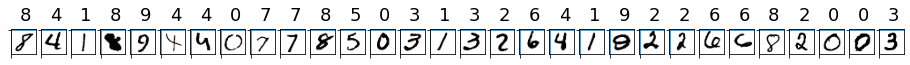

In [6]:
# make sure utils.py is in the same directory as this code
from utils import load_data, one_hot_encode

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data(os.path.join(data_folder, 'train-images-idx3-ubyte.gz'), False) / 255.0
X_test = load_data(os.path.join(data_folder, 't10k-images-idx3-ubyte.gz'), False) / 255.0
y_train = load_data(os.path.join(data_folder, 'train-labels-idx1-ubyte.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 't10k-labels-idx1-ubyte.gz'), True).reshape(-1)

# now let's show some randomly chosen images from the training set.
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

Now you have an idea of what these images look like and the expected prediction outcome.

## (Optional) Create Dataset and Register Dataset
A FileDataset references one or multiple files in your datastores or public urls. The files can be of any format. FileDataset provides you with the ability to download or mount the files to your compute. By creating a dataset, you create a reference to the data source location. If you applied any subsetting transformations to the dataset, they will be stored in the dataset as well. The data remains in its existing location, so no extra storage cost is incurred. [Learn More](https://aka.ms/azureml/howto/createdatasets)

In [7]:
from azureml.core.dataset import Dataset
web_paths = ['https://azureopendatastorage.blob.core.windows.net/mnist/train-images-idx3-ubyte.gz',
             'https://azureopendatastorage.blob.core.windows.net/mnist/train-labels-idx1-ubyte.gz',
             'https://azureopendatastorage.blob.core.windows.net/mnist/t10k-images-idx3-ubyte.gz',
             'https://azureopendatastorage.blob.core.windows.net/mnist/t10k-labels-idx1-ubyte.gz'
            ]
dataset = Dataset.File.from_files(path = web_paths)

'''
Use the `register()` method to register datasets to your workspace so they can be shared with others, reused across various experiments, and referred to by name in your training script.
You can try get the dataset first to see if it's already registered.
'''

dataset = dataset.register(workspace = ws,
                               name = 'mnist-dataset',
                               description='training and test dataset',
                               create_new_version=True)

print("Dataset Created and Registered")

Dataset Created and Registered


## Create or Attach existing AmlCompute
You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for training your model. In this tutorial, you create `AmlCompute` as your training compute resource.

If we could not find the cluster with the given name, then we will create a new cluster here. We will create an `AmlCompute` cluster of `STANDARD_NC6` GPU VMs. This process is broken down into 3 steps:
1. create the configuration (this step is local and only takes a second)
2. create the cluster (this step will take about **20 seconds**)
3. provision the VMs to bring the cluster to the initial size (of 1 in this case). This step will take about **3-5 minutes** and is providing only sparse output in the process. Please make sure to wait until the call returns before moving to the next cell

In [8]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "cpu-cluster"
compute_target = ComputeTarget(workspace=ws, name=cluster_name)

##uncomment if you don't have a compute
'''
try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_DS3_v2', 
                                                           max_nodes=4)
    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
'''
# can poll for a minimum number of nodes and for a specific timeout. 
# if no min node count is provided it uses the scale settings for the cluster
compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

# use get_status() to get a detailed status for the current cluster. 
# print(compute_target.get_status().serialize())

Found existing compute target
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## Copy the training files into the script folder
The Keras training script is already created for you. You can simply copy it into the script folder, together with the utility library used to load compressed data file into numpy array.

In [9]:
import shutil

# the training logic is in the keras_mnist.py file.
shutil.copy('./keras_mnist.py', script_folder)

# the utils.py just helps loading data from the downloaded MNIST dataset into numpy arrays.
shutil.copy('./utils.py', script_folder)

'./keras-mnist/utils.py'

## Construct neural network in Keras
In the training script `keras_mnist.py`, it creates a very simple DNN (deep neural network), with just 2 hidden layers. The input layer has 28 * 28 = 784 neurons, each representing a pixel in an image. The first hidden layer has 300 neurons, and the second hidden layer has 100 neurons. The output layer has 10 neurons, each representing a targeted label from 0 to 9.

![DNN](nn.png)

### (Optional) Create an environment
Define a conda environment YAML file with your training script dependencies, which include TensorFlow, Keras and matplotlib, and create an Azure ML environment.

In [11]:
%%writefile conda_dependencies.yml

channels:
- conda-forge
dependencies:
- python=3.6.2
- pip:
  - h5py<=2.10.0
  - azureml-defaults
  - tensorflow-gpu==2.0.0
  - keras<=2.3.1
  - matplotlib

Overwriting conda_dependencies.yml


In [12]:
from azureml.core import Environment

keras_env = Environment.from_conda_specification(name = 'keras-2.3.1', file_path = './conda_dependencies.yml')

## Configure the training job

Create a ScriptRunConfig object to specify the configuration details of your training job, including your training script, environment to use, and the compute target to run on.

In [13]:
from azureml.core import ScriptRunConfig
dataset = Dataset.get_by_name(ws, 'mnist-dataset')

args = ['--data-folder', dataset.as_named_input('mnist').as_mount(),
        '--batch-size', 50,
        '--first-layer-neurons', 300,
        '--second-layer-neurons', 100,
        '--learning-rate', 0.001]

src_KNN = ScriptRunConfig(source_directory=script_folder,
                      script='keras_mnist.py',
                      arguments=args,
                      compute_target=compute_target)

## Submit job to run
Submit the ScriptRunConfig to the Azure ML experiment to kick off the execution.

In [14]:
run_KNN = exp_KNN.submit(src_KNN)

### Monitor the Run
As the Run is executed, it will go through the following stages:

1. Preparing: A docker image is created matching the Python environment specified by the Azure ML environment

2. Scaling: If the compute needs to be scaled up (i.e. the AmlCompute cluster requires more nodes to execute the run than currently available)

3. Running: All scripts in the script folder are uploaded to the compute target

4. Post-Processing: The `./outputs` folder of the run is copied over to the run history

There are multiple ways to check the progress of a running job. We can use a Jupyter notebook widget. 

In [15]:
from azureml.widgets import RunDetails
RunDetails(run_KNN).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

We can also periodically check the status of the run object, and navigate to Azure portal to monitor the run.

In [16]:
run_KNN

Experiment,Id,Type,Status,Details Page,Docs Page
KNN_demo,KNN_demo_1608088820_4f2b4b4d,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [17]:
run_KNN.wait_for_completion(show_output=True)

RunId: KNN_demo_1608088820_4f2b4b4d
Web View: https://ml.azure.com/experiments/KNN_demo/runs/KNN_demo_1608088820_4f2b4b4d?wsid=/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourcegroups/PipelinesUsabilityStudy/workspaces/shwinne-demos

Streaming azureml-logs/55_azureml-execution-tvmps_c85df249b992dfcd363d12360dc700657576b5da2f6d7ee1c20978accaf215d4_d.txt

2020-12-16T03:20:40Z Starting output-watcher...
2020-12-16T03:20:40Z IsDedicatedCompute == True, won't poll for Low Pri Preemption
2020-12-16T03:20:41Z Executing 'Copy ACR Details file' on 10.0.0.4
2020-12-16T03:20:41Z Copy ACR Details file succeeded on 10.0.0.4. Output: 
>>>   
>>>   
Login Succeeded
Using default tag: latest
latest: Pulling from azureml/azureml_e9607b2514b066c851012848913ba19f
Digest: sha256:b7eb97d50f0ea70135bab50ea27148fbc7f6c9a79798250d4838c45afd78b60a
Status: Image is up to date for viennaglobal.azurecr.io/azureml/azureml_e9607b2514b066c851012848913ba19f:latest
viennaglobal.azurecr.io/azureml/azureml_e96

ActivityFailedException: ActivityFailedException:
	Message: Activity Failed:
{
    "error": {
        "code": "UserError",
        "message": "AzureMLCompute job failed.\nJobFailed: Submitted script failed with a non-zero exit code; see the driver log file for details.\n\tReason: Job failed with non-zero exit Code",
        "messageFormat": "{Message}",
        "messageParameters": {
            "Message": "AzureMLCompute job failed.\nJobFailed: Submitted script failed with a non-zero exit code; see the driver log file for details.\n\tReason: Job failed with non-zero exit Code"
        },
        "details": [],
        "innerError": {
            "code": "BadArgument",
            "innerError": {
                "code": "AmlComputeBadRequest"
            }
        }
    },
    "correlation": {
        "operation": null,
        "request": "77b2df37760f0e74"
    },
    "environment": "westus",
    "location": "westus",
    "time": "2020-12-16T03:21:22.662554Z",
    "componentName": "execution-worker"
}
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Activity Failed:\n{\n    \"error\": {\n        \"code\": \"UserError\",\n        \"message\": \"AzureMLCompute job failed.\\nJobFailed: Submitted script failed with a non-zero exit code; see the driver log file for details.\\n\\tReason: Job failed with non-zero exit Code\",\n        \"messageFormat\": \"{Message}\",\n        \"messageParameters\": {\n            \"Message\": \"AzureMLCompute job failed.\\nJobFailed: Submitted script failed with a non-zero exit code; see the driver log file for details.\\n\\tReason: Job failed with non-zero exit Code\"\n        },\n        \"details\": [],\n        \"innerError\": {\n            \"code\": \"BadArgument\",\n            \"innerError\": {\n                \"code\": \"AmlComputeBadRequest\"\n            }\n        }\n    },\n    \"correlation\": {\n        \"operation\": null,\n        \"request\": \"77b2df37760f0e74\"\n    },\n    \"environment\": \"westus\",\n    \"location\": \"westus\",\n    \"time\": \"2020-12-16T03:21:22.662554Z\",\n    \"componentName\": \"execution-worker\"\n}"
    }
}

In the outputs of the training script, it prints out the Keras version number. Please make a note of it.

## Download the saved model

In the training script, the Keras model is saved into two files, `model.json` and `model.h5`, in the `outputs/models` folder on the gpu-cluster AmlCompute node. Azure ML automatically uploaded anything written in the `./outputs` folder into run history file store. Subsequently, we can use the `run` object to download the model files. They are under the the `outputs/model` folder in the run history file store, and are downloaded into a local folder named `model`.

In [42]:
# create a model folder in the current directory
os.makedirs('./model', exist_ok=True)

for f in run_KNN.get_file_names():
    if f.startswith('outputs/model'):
        output_file_path = os.path.join('./model', f.split('/')[-1])
        print('Downloading from {} to {} ...'.format(f, output_file_path))
        run_KNN.download_file(name=f, output_file_path=output_file_path)

## Predict on the test set (Optional)
Let's check the version of the local Keras. Make sure it matches with the version number printed out in the training script. Otherwise you might not be able to load the model properly.

    import keras
    import tensorflow as tf

    print("Keras version:", keras.__version__)
    print("Tensorflow version:", tf.__version__)

Now let's load the downloaded model.

    from keras.models import model_from_json

    # load json and create model
    json_file = open('model/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("model/model.h5")
    print("Model loaded from disk.")

Feed test dataset to the persisted model to get predictions.

    # evaluate loaded model on test data
    loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    y_test_ohe = one_hot_encode(y_test, 10)
    y_hat = np.argmax(loaded_model.predict(X_test), axis=1)

    # print the first 30 labels and predictions
    print('labels:  \t', y_test[:30])
    print('predictions:\t', y_hat[:30])

Calculate the overall accuracy by comparing the predicted value against the test set.

    print("Accuracy on the test set:", np.average(y_hat == y_test))

## Intelligent hyperparameter tuning
We have trained the model with one set of hyperparameters, now let's how we can do hyperparameter tuning by launching multiple runs on the cluster. First let's define the parameter space using random sampling.

In [43]:
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, loguniform

## I NEED HELP IN HYPERPARAMETER TUNING -- Show me how to hypertune
ps = RandomParameterSampling(
    {
        '--batch-size': choice(25, 50, 100),
        '--first-layer-neurons': choice(10, 50, 200, 300, 500),
        '--second-layer-neurons': choice(10, 50, 200, 500),
        '--learning-rate': loguniform(-6, -1)
    }
)

Next, we will create a new ScriptRunConfig without the above arguments since they will be passed in later by our Hyperdrive configuration. Note we still need to keep the `data-folder` parameter since that's not a hyperparameter we will sweep.

In [44]:
args = ['--data-folder', dataset.as_named_input('mnist').as_mount()]

src = ScriptRunConfig(source_directory=script_folder,
                      script='keras_mnist.py',
                      arguments=args,
                      compute_target=compute_target)

Now we will define an early termnination policy. The `BanditPolicy` basically states to check the job every 2 iterations. If the primary metric (defined later) falls outside of the top 10% range, Azure ML terminate the job. This saves us from continuing to explore hyperparameters that don't show promise of helping reach our target metric.

In [45]:
## I NEED HELP IN HYPERPARAMETER TUNING -- Show me how to hypertune
policy = BanditPolicy(evaluation_interval=2, slack_factor=0.1)

Now we are ready to configure a run configuration object, and specify the primary metric `Accuracy` that's recorded in your training runs. If you go back to visit the training script, you will notice that this value is being logged after every epoch (a full batch set). We also want to tell the service that we are looking to maximizing this value. We also set the number of samples to 20, and maximal concurrent job to 4, which is the same as the number of nodes in our computer cluster.

In [46]:
hyperdrive_config = HyperDriveConfig(run_config=src,
                                     hyperparameter_sampling=ps,
                                     policy=policy,
                                     primary_metric_name='Accuracy',
                                     primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
                                     max_total_runs=20,
                                     max_concurrent_runs=4)

Finally, let's launch the hyperparameter tuning job.

In [47]:
hyperdrive_run = exp_KNN.submit(config=hyperdrive_config)

We can use a run history widget to show the progress. Be patient as this might take a while to complete.

In [48]:
RunDetails(hyperdrive_run).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

In [49]:
hyperdrive_run.wait_for_completion(show_output=True)

RunId: HD_172baac4-6e99-4a4f-a4fa-ec85bb8139ad
Web View: https://ml.azure.com/experiments/KNN_demo/runs/HD_172baac4-6e99-4a4f-a4fa-ec85bb8139ad?wsid=/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a1a3b06324/resourcegroups/PipelinesUsabilityStudy/workspaces/shwinne-demos

Streaming azureml-logs/hyperdrive.txt

"<START>[2020-12-16T19:10:30.492430][API][INFO]Experiment created<END>\n""<START>[2020-12-16T19:10:30.944732][GENERATOR][INFO]Trying to sample '4' jobs from the hyperparameter space<END>\n""<START>[2020-12-16T19:10:31.158484][GENERATOR][INFO]Successfully sampled '4' jobs, they will soon be submitted to the execution target.<END>\n"<START>[2020-12-16T19:10:32.5873510Z][SCHEDULER][INFO]The execution environment is being prepared. Please be patient as it can take a few minutes.<END>

Execution Summary
RunId: HD_172baac4-6e99-4a4f-a4fa-ec85bb8139ad
Web View: https://ml.azure.com/experiments/KNN_demo/runs/HD_172baac4-6e99-4a4f-a4fa-ec85bb8139ad?wsid=/subscriptions/15ae9cb6-95c1-483d-a0e3-b1a

{'runId': 'HD_172baac4-6e99-4a4f-a4fa-ec85bb8139ad',
 'target': 'cpu-cluster',
 'status': 'Canceled',
 'startTimeUtc': '2020-12-16T19:10:30.260939Z',
 'endTimeUtc': '2020-12-16T19:16:37.054653Z',
 'error': {'error': {'code': 'UserError',
   'message': 'User errors were found in at least one of the child runs.',
   'messageParameters': {},
   'details': []},
  'time': '0001-01-01T00:00:00.000Z'},
 'warnings': [{'source': 'SecondaryError',
   'message': '{\n  "error": {\n    "code": "UserError",\n    "severity": null,\n    "message": "User errors were found in at least one of the child runs.",\n    "messageFormat": null,\n    "messageParameters": {},\n    "referenceCode": null,\n    "detailsUri": null,\n    "target": null,\n    "details": [],\n    "innerError": null,\n    "debugInfo": null\n  },\n  "correlation": null,\n  "environment": null,\n  "location": null,\n  "time": "0001-01-01T00:00:00+00:00",\n  "componentName": null\n}'}],
 'properties': {'primary_metric_config': '{"name": "Ac

In [50]:
assert(hyperdrive_run.get_status() == "Completed")

AssertionError: 

### DEMO STOPS HERE